## Prepare the workspace

In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
import torch.optim as optim
from torch.utils import data
from PIL import Image
import numpy as np
import os, random
import signal
from torch import nn
import torch.nn.functional as F
import tqdm
from torchvision import datasets, transforms, models

from contextlib import contextmanager

import requests


import matplotlib
import matplotlib.pyplot as plt


%config IPCompleter.greedy=True

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

**Method 1**
```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


**Method 2**
```bash
!cp -r /data/ .
```

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [18]:
# Define data augmentation and normalization transforms for the training set
train_transforms = transforms.Compose([
    # Randomly crop and resize images to 224x224
    transforms.RandomResizedCrop(224),  
    # Randomly flip images horizontally with a 50% chance
    transforms.RandomHorizontalFlip(p=0.5),  
    # Convert images to tensors
    transforms.ToTensor(),  
    # Normalize images with mean and standard deviation values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transforms for the validation and testing sets
valid_transforms = test_transforms = transforms.Compose([
    # Resize images to 256x256 and then center crop to 224x224
    transforms.Resize(256),  
    transforms.CenterCrop(224),  
    # Convert images to tensors
    transforms.ToTensor(),
    # Normalize images with mean and standard deviation values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the flower species datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create data loaders for the training, validation, and testing sets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
# Import necessary libraries
import json
import collections

# Load the JSON file containing category names
with open('cat_to_name.json', 'r') as file:
    category_names = json.load(file)

# Convert category IDs to integers and store in a dictionary
category_names = {int(key): value for key, value in category_names.items()}

# Sort the category names in ascending order of their IDs
sorted_category_names = collections.OrderedDict(sorted(category_names.items()))

# Print the sorted category names
print("Sorted Category Names:")
print(sorted_category_names)

Sorted Category Names:
OrderedDict([(1, 'pink primrose'), (2, 'hard-leaved pocket orchid'), (3, 'canterbury bells'), (4, 'sweet pea'), (5, 'english marigold'), (6, 'tiger lily'), (7, 'moon orchid'), (8, 'bird of paradise'), (9, 'monkshood'), (10, 'globe thistle'), (11, 'snapdragon'), (12, "colt's foot"), (13, 'king protea'), (14, 'spear thistle'), (15, 'yellow iris'), (16, 'globe-flower'), (17, 'purple coneflower'), (18, 'peruvian lily'), (19, 'balloon flower'), (20, 'giant white arum lily'), (21, 'fire lily'), (22, 'pincushion flower'), (23, 'fritillary'), (24, 'red ginger'), (25, 'grape hyacinth'), (26, 'corn poppy'), (27, 'prince of wales feathers'), (28, 'stemless gentian'), (29, 'artichoke'), (30, 'sweet william'), (31, 'carnation'), (32, 'garden phlox'), (33, 'love in the mist'), (34, 'mexican aster'), (35, 'alpine sea holly'), (36, 'ruby-lipped cattleya'), (37, 'cape flower'), (38, 'great masterwort'), (39, 'siam tulip'), (40, 'lenten rose'), (41, 'barbeton daisy'), (42, 'daffod

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. 

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
model = models.efficientnet_b2(pretrained=True)
model       

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /home/student/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 158MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
# Freeze the pre-trained model weights
for param in model.parameters():
    param.requires_grad = False

# Identify trainable layers
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer {name} is trainable")
    else:
        print(f"Layer {name} is frozen")

Layer features.0.0.weight is frozen
Layer features.0.1.weight is frozen
Layer features.0.1.bias is frozen
Layer features.1.0.block.0.0.weight is frozen
Layer features.1.0.block.0.1.weight is frozen
Layer features.1.0.block.0.1.bias is frozen
Layer features.1.0.block.1.fc1.weight is frozen
Layer features.1.0.block.1.fc1.bias is frozen
Layer features.1.0.block.1.fc2.weight is frozen
Layer features.1.0.block.1.fc2.bias is frozen
Layer features.1.0.block.2.0.weight is frozen
Layer features.1.0.block.2.1.weight is frozen
Layer features.1.0.block.2.1.bias is frozen
Layer features.1.1.block.0.0.weight is frozen
Layer features.1.1.block.0.1.weight is frozen
Layer features.1.1.block.0.1.bias is frozen
Layer features.1.1.block.1.fc1.weight is frozen
Layer features.1.1.block.1.fc1.bias is frozen
Layer features.1.1.block.1.fc2.weight is frozen
Layer features.1.1.block.1.fc2.bias is frozen
Layer features.1.1.block.2.0.weight is frozen
Layer features.1.1.block.2.1.weight is frozen
Layer features.1.1

In [8]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(1408, out_features=102, bias=True)
)

for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"Non-trainable layer: {name}")
    else:
        print(f"Trainable layer: {name}")

Non-trainable layer: features.0.0.weight
Non-trainable layer: features.0.1.weight
Non-trainable layer: features.0.1.bias
Non-trainable layer: features.1.0.block.0.0.weight
Non-trainable layer: features.1.0.block.0.1.weight
Non-trainable layer: features.1.0.block.0.1.bias
Non-trainable layer: features.1.0.block.1.fc1.weight
Non-trainable layer: features.1.0.block.1.fc1.bias
Non-trainable layer: features.1.0.block.1.fc2.weight
Non-trainable layer: features.1.0.block.1.fc2.bias
Non-trainable layer: features.1.0.block.2.0.weight
Non-trainable layer: features.1.0.block.2.1.weight
Non-trainable layer: features.1.0.block.2.1.bias
Non-trainable layer: features.1.1.block.0.0.weight
Non-trainable layer: features.1.1.block.0.1.weight
Non-trainable layer: features.1.1.block.0.1.bias
Non-trainable layer: features.1.1.block.1.fc1.weight
Non-trainable layer: features.1.1.block.1.fc1.bias
Non-trainable layer: features.1.1.block.1.fc2.weight
Non-trainable layer: features.1.1.block.1.fc2.bias
Non-traina

In [9]:
# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with a learning rate of 0.001
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Check if a CUDA-enabled GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the available device (GPU or CPU)
model.to(device)

# Print a message indicating the device being used
print(f"Using device: {device}")

Using device: cuda


In [10]:
num_epochs = 5
train_loss_history, valid_loss_history = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    train_loader_progress = tqdm.tqdm(train_loader, total=len(train_loader), desc=f"Training Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in train_loader_progress:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        train_loader_progress.set_postfix(loss=epoch_loss / len(train_loader))

    train_loss = epoch_loss / len(train_loader)
    train_loss_history.append(train_loss)

    model.eval()
    epoch_loss = 0.0
    correct_predictions, total_samples = 0, 0
    valid_loader_progress = tqdm.tqdm(valid_loader, total=len(valid_loader), desc="Validating")
    with torch.no_grad():
        for inputs, labels in valid_loader_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            _, predicted_labels = outputs.max(1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()
            valid_loader_progress.set_postfix(loss=epoch_loss / len(valid_loader))

    valid_loss = epoch_loss / len(valid_loader)
    valid_loss_history.append(valid_loss)
    accuracy = 100 * correct_predictions / total_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, '
          f'Accuracy: {accuracy:.2f}%')

Validating: 100%|██████████| 13/13 [03:05<00:00, 14.23s/it, loss=1.83]


Epoch [1/5], Train Loss: 3.2220, Valid Loss: 1.8336, Accuracy: 80.56%


Validating: 100%|██████████| 13/13 [03:09<00:00, 14.56s/it, loss=1.01] 


Epoch [2/5], Train Loss: 1.6697, Valid Loss: 1.0134, Accuracy: 89.49%


Validating: 100%|██████████| 13/13 [03:18<00:00, 15.24s/it, loss=0.702]


Epoch [3/5], Train Loss: 1.1560, Valid Loss: 0.7020, Accuracy: 90.46%


Validating: 100%|██████████| 13/13 [03:19<00:00, 15.35s/it, loss=0.574]


Epoch [4/5], Train Loss: 0.9061, Valid Loss: 0.5738, Accuracy: 91.93%


Validating: 100%|██████████| 13/13 [03:08<00:00, 14.52s/it, loss=0.475]

Epoch [5/5], Train Loss: 0.7842, Valid Loss: 0.4749, Accuracy: 92.05%


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [19]:

import tqdm

# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions, total_samples = 0, 0
    test_loader_progress = tqdm.tqdm(test_loader, total=len(test_loader), desc="Testing")

    # Check if the test_loader is empty
    if len(test_loader) == 0:
        print("Test loader is empty.")
        return

    # Check if the dataset is empty
    if len(test_loader.dataset) == 0:
        print("Test dataset is empty.")
        return

    print("Starting testing...")  # Debugging print

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader_progress:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            test_loss += loss.item()  # Accumulate loss

            _, predicted_labels = outputs.max(1)  # Get predicted labels
            total_samples += labels.size(0)  # Update total samples
            correct_predictions += (predicted_labels == labels).sum().item()  # Update correct predictions
            test_loader_progress.set_postfix(loss=test_loss / (test_loader_progress.n + 1))

    if total_samples > 0:  # Check to avoid division by zero
        average_test_loss = test_loss / len(test_loader)  # Average loss for the test set
        test_accuracy = 100 * correct_predictions / total_samples  # Calculate accuracy

        print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    else:
        print("No samples in the test set.")

# Call the test_model function after training and validation
test_model(model, test_loader, criterion, device)

Testing:   0%|          | 0/13 [00:00<?, ?it/s]

Starting testing...


Testing: 100%|██████████| 13/13 [03:03<00:00, 14.12s/it, loss=0.531]

Test Loss: 0.5309, Test Accuracy: 91.21%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [20]:
# TODO: Save the checkpoint 

# Attach class_to_idx to the model
model.class_to_idx = train_data.class_to_idx

# Create a checkpoint dictionary
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_epochs': num_epochs,
    'class_to_idx': model.class_to_idx
}

# Save the checkpoint
torch.save(checkpoint, 'model_checkpoint.pth')
print("Checkpoint saved successfully.")

Checkpoint saved successfully.


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [21]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'),weights_only=True)
    model = models.efficientnet_b2(pretrained=True)

    # Freeze the parameters (if needed)
    for param in model.parameters():
        param.requires_grad = False

    # Load the classifier structure
    model.classifier = checkpoint['classifier']

    # Load the state dictionary into the model
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load the class_to_idx mapping
    model.class_to_idx = checkpoint['class_to_idx']

    # Optionally, set the model to evaluation mode
    model.eval()

    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [22]:
from collections import OrderedDict
def load_checkpoint(filepath):
        checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
        model = models.efficientnet_b2(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        model.classifier = checkpoint['classifier'] # load classifier

        model.load_state_dict(checkpoint['model_state_dict'])
        model.class_to_idx = checkpoint['class_to_idx']
        model.eval()

        return model

In [23]:

def process_image(image_path):
    pil_image = Image.open(image_path)
    pil_image = pil_image.resize((256, 256))
    left = (pil_image.width - 224) / 2
    top = (pil_image.height - 224) / 2
    right = (pil_image.width + 224) / 2
    bottom = (pil_image.height + 224) / 2
    pil_image = pil_image.crop((left, top, right, bottom))
    np_image = np.array(pil_image) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    np_image = np_image.transpose((2, 0, 1))
    return torch.tensor(np_image).float()

def predict(image_path, model, topk=5):
    image = process_image(image_path)
    image = image.unsqueeze(0)
    model.eval()

    # Move the image to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        ps = torch.nn.functional.softmax(outputs, dim=1)
        top_p, top_class = ps.topk(topk, dim=1)

    # Convert to lists and move to CPU
    top_p = top_p.cpu().numpy()[0]
    top_class = top_class.cpu().numpy()[0]

    # Invert the class_to_idx dictionary to get class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    top_classes = [idx_to_class[i] for i in top_class]

    return top_p, top_classes
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [24]:
def display_image(image_tensor, axis=None, image_title=None):

    if axis is None:
        fig, axis = plt.subplots()

    # Convert the image tensor from (C, H, W) to (H, W, C)
    image_array = image_tensor.numpy().transpose((1, 2, 0))

    # Reverse normalization
    mean_values = np.array([0.485, 0.456, 0.406])
    std_values = np.array([0.229, 0.224, 0.225])
    image_array = std_values * image_array + mean_values

    # Ensure pixel values are within [0, 1]
    image_array = np.clip(image_array, 0, 1)

    axis.imshow(image_array)
    if image_title:
        axis.set_title(image_title)  # Set the title if provided
    axis.axis('off')  # Hide axes for better visualization

    return axis

import seaborn as sns

def visualize_prediction(image_file_path, trained_model):
    """Visualize the prediction results for a given image."""
    plt.figure(figsize=(6, 10))

    # Display the image
    subplot_axis = plt.subplot(2, 1, 1)
    processed_image = process_image(image_file_path)

    # Extract the class from the image path
    class_label = image_file_path.split('/')[-2]
    image_title = cat_to_name.get(class_label, 'Unknown Flower')  # Handle missing keys
    display_image(processed_image, axis=subplot_axis, image_title=image_title)

    # Get predictions
    probabilities, predicted_classes = predict(image_file_path, trained_model)
    class_labels = [cat_to_name.get(cls, 'Unknown Flower') for cls in predicted_classes]  # Handle missing keys

    # Plot the probabilities
    plt.subplot(2, 1, 2)
    sns.barplot(x=probabilities, y=class_labels, color=sns.color_palette()[0])
    plt.xlabel('Probability')
    plt.ylabel('Class Labels')
    plt.title('Top Predictions')
    plt.show()

print("Prediction visualization function is ready.")

Prediction visualization function is ready.


In [41]:

def preprocess_image(image_path):
    # Check if the file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File not found: {image_path}")
    
    # Open the image
    image = Image.open(image_path)
    
    # Resize to maintain a consistent size
    image = image.resize((256, 256))
    
    # Define cropping dimensions
    crop_size = 224
    left_margin = (image.width - crop_size) / 2
    top_margin = (image.height - crop_size) / 2
    right_margin = left_margin + crop_size
    bottom_margin = top_margin + crop_size
    
    # Crop the image to the desired size
    image = image.crop((left_margin, top_margin, right_margin, bottom_margin))
    
    # Ensure the image is in RGB format
    image = image.convert("RGB")
    
    # Optionally: Normalize and convert to a tensor here if required by your model

    return image

# Example usage
image_path = 'flowers/test/2/image_05107.jpg'  # Adjust the path accordingly
try:
    output_image = preprocess_image(image_path)
    print("Image preprocessing completed successfully.")
except FileNotFoundError as error:
    print(error)


Image preprocessing completed successfully.


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [46]:

import torch.nn.functional as F

# Assuming model.class_to_idx has been set correctly
model.class_to_idx = image[0].class_to_idx  # 0 = train

def predict(image_path, model, topk=5):
    """Predict the class of an image using a trained deep learning model."""
    


TypeError: 'JpegImageFile' object is not subscriptable

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

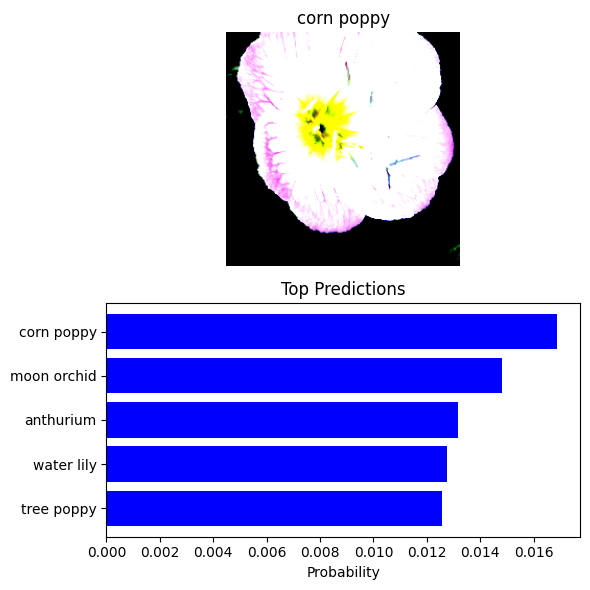

In [53]:
# TODO: Display an image along with the top 5 classes

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import json

# Load the class names from the JSON file
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Load the model and modify the classifier
model = models.efficientnet_b2(weights='DEFAULT')
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 102)  # Adjust for your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# Define image processing and prediction functions
def process_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path)
    return preprocess(img).unsqueeze(0).to(device)

def predict(image_path, model, topk=5):
    img_tensor = process_image(image_path)
    with torch.no_grad():
        output = model(img_tensor)
    probs = torch.softmax(output, dim=1)
    return probs.topk(topk)

# Function to show the image
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    # Clip the image to [0, 1] range for display
    image = image.cpu().numpy()
    image = np.clip(image, 0, 1)  # Ensure values are in the range [0, 1]
    ax.imshow(image.transpose(1, 2, 0))  # Convert from tensor to image format
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

# Display function
def display_prediction(image_path):
    probs, classes = predict(image_path, model)
    classes = classes.cpu().numpy()[0]
    probs = probs.cpu().numpy()[0]

    # Plotting
    plt.figure(figsize=(6, 6))
    
    # Image display
    ax1 = plt.subplot(211)
    img = process_image(image_path).squeeze(0)  # Remove batch dimension for imshow
    imshow(img, ax=ax1, title=cat_to_name[str(classes[0])])

    # Bar chart for probabilities
    ax2 = plt.subplot(212)
    names = [cat_to_name[str(index)] for index in classes]
    ax2.barh(names, probs, color='blue')
    ax2.invert_yaxis()  # Invert y-axis for better readability
    ax2.set_xlabel('Probability')
    ax2.set_title('Top Predictions')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = 'flowers/test/1/image_06743.jpg'  
display_prediction(image_path)

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [2]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace
!rm checkpoint.pth